In [42]:
from sklearn.datasets import fetch_california_housing

import pandas as pd
import numpy as np
import torch


data = pd.read_csv('weatherAUS_processed.csv')
locations, features, targets = data['Location'], data.drop(['Location', 'NextDayMaxTemp'], axis=1), data['NextDayMaxTemp']

locations = torch.tensor(locations, dtype=torch.int64)
features = torch.tensor(features.values, dtype=torch.get_default_dtype())
targets = torch.tensor(targets.values, dtype=torch.get_default_dtype())
number_of_data = targets.shape[0]
permutation = torch.tensor(np.random.permutation(number_of_data), dtype=torch.int64)
locations = locations[permutation]
features = features[permutation]
targets = targets[permutation]

n_train = 2 * number_of_data // 10
n_valid = number_of_data // 10
n_test = number_of_data - n_train

l_train = locations[:n_train]
l_valid = locations[n_train:n_train+n_valid]
l_test = locations[n_train+n_valid:]
X_train = features[:n_train]
X_valid = features[n_train:n_train+n_valid]
X_test = features[n_train+n_valid:]
y_train = targets[:n_train].reshape(-1, 1)
y_valid = targets[n_train:n_train+n_valid].reshape(-1, 1)
y_test = targets[n_train+n_valid:].reshape(-1, 1)

mean_X = torch.mean(X_train, dim=0)
std_X = torch.std(X_train, dim=0, correction=0)
std_X[std_X == 0.0] = 1.0  # avoid division by zero
X_train = (X_train - mean_X) / std_X
X_valid = (X_valid - mean_X) / std_X
X_test = (X_test - mean_X) / std_X

train_dataset = torch.utils.data.TensorDataset(l_train, X_train, y_train)
valid_dataset = torch.utils.data.TensorDataset(l_valid, X_valid, y_valid)
test_dataset = torch.utils.data.TensorDataset(l_test, X_test, y_test)

In [67]:
n_layers = 2
n_features = X_train.shape[1]
n_neurons_embedding = 512
n_neurons_per_layer = 512

class FirstLayer(torch.nn.Module):
    def __init__(self, n_neurons_embedding):
        super().__init__()
        self.location_embedding = torch.nn.Embedding(26, n_neurons_embedding)

    def forward(self, loc_x):
        loc, x = loc_x
        return torch.cat(
            (self.location_embedding(loc), x),
            dim=1
        )

model = torch.nn.Sequential(
    FirstLayer(n_neurons_embedding),
    torch.nn.Linear(n_neurons_embedding+n_features, n_neurons_per_layer),
    torch.nn.SiLU(),
    torch.nn.Linear(n_neurons_per_layer, n_neurons_per_layer),
    torch.nn.SiLU(),
    torch.nn.Linear(n_neurons_per_layer, 1),
)


In [68]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

11306
5653
39571


In [69]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

with torch.no_grad():
    y_pred = model((l_valid, X_valid))
    valid_loss = torch.nn.functional.mse_loss(y_pred, y_valid)
    print(f"Before training: Valid loss: {valid_loss:.4f}")

best_model = None
best_valid_loss = float("inf")
for epoch in range(100):
    train_loss = 0.0
    for l_batch, X_batch, y_batch in train_dataloader:
        y_pred = model((l_batch, X_batch))
        loss = torch.nn.functional.mse_loss(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            y_pred = model((l_valid, X_valid))
            valid_loss = torch.nn.functional.mse_loss(y_pred, y_valid)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_model = model.state_dict()
            print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}")


Before training: Valid loss: 635.6154


Epoch: 0, Train loss: 6562.3821, Valid loss: 11.9765
Epoch: 10, Train loss: 741.1174, Valid loss: 8.4156
Epoch: 20, Train loss: 704.1350, Valid loss: 8.1297
Epoch: 30, Train loss: 661.8171, Valid loss: 8.1188
Epoch: 40, Train loss: 639.3186, Valid loss: 8.5296
Epoch: 50, Train loss: 601.5196, Valid loss: 7.9446
Epoch: 60, Train loss: 577.2754, Valid loss: 8.3578
Epoch: 70, Train loss: 549.8020, Valid loss: 8.3083
Epoch: 80, Train loss: 486.1299, Valid loss: 8.8412
Epoch: 90, Train loss: 418.3447, Valid loss: 8.8119


In [70]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [71]:
model_without_last_layer = model[:-1]
last_layer = model[-1]

assert torch.allclose(last_layer(model_without_last_layer((l_valid, X_valid))), model((l_valid, X_valid)))

In [72]:
from tqdm import tqdm

features_last_layer = model_without_last_layer((l_train, X_train))
covariance = features_last_layer.T @ features_last_layer

estimated_variances = []
actual_variances = []
with torch.no_grad():
    for l_batch, X_batch, y_batch in tqdm(test_dataloader):
        y_pred = model((l_batch, X_batch))
        actual_variances.append((y_pred - y_batch) ** 2)
        features_last_layer = model_without_last_layer((l_batch, X_batch))
        estimated_variances.append(
            torch.diag(features_last_layer @ torch.linalg.solve(covariance, features_last_layer.T))
        )
estimated_variances = torch.cat(estimated_variances, dim=0)
actual_variances = torch.cat(actual_variances, dim=0)


100%|██████████| 310/310 [00:04<00:00, 66.39it/s]


In [73]:
estimated_variances = estimated_variances.cpu().numpy()
actual_variances = actual_variances.cpu().numpy()

Other bins contain 100 elements.
The last bin contains only 71 elements.


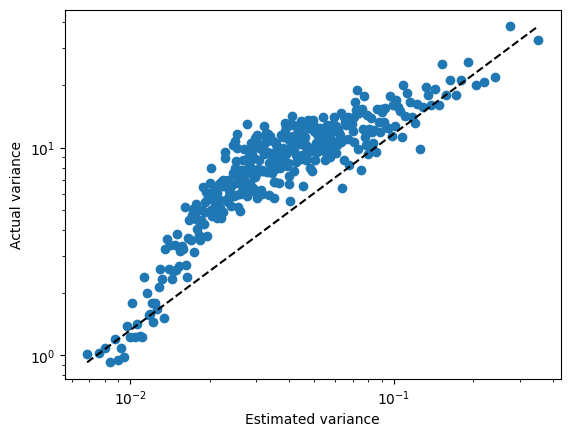

In [74]:
n_per_bin = 100

sorting = np.argsort(estimated_variances)
estimated_variances = estimated_variances[sorting]
actual_variances = actual_variances[sorting]

bins = np.arange(0, len(estimated_variances), n_per_bin)
estimated_variances_avg = np.array([np.mean(estimated_variances[bins[i] : bins[i + 1]]) for i in range(len(bins) - 1)])
actual_variances_avg = np.array([np.mean(actual_variances[bins[i] : bins[i + 1]]) for i in range(len(bins) - 1)])

# Warn about the fact that the last bin is not full:
print(f"Other bins contain {n_per_bin} elements.")
print(f"The last bin contains only {len(estimated_variances) - bins[-1]} elements.")

import matplotlib.pyplot as plt

plt.plot(estimated_variances_avg, actual_variances_avg, "o")
plt.plot([np.min(estimated_variances_avg), np.max(estimated_variances_avg)], [np.min(actual_variances_avg), np.max(actual_variances_avg)], "k--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Estimated variance")
plt.ylabel("Actual variance")
plt.show()